# Participant demographics compared to U.S. Census Bureau Data

Make comparisons for the entire sample, and the sample of participants who did consent to share their browser data.


When possible, we restrict the census data to the 18+ population, because our participants were required to be 18 years or older.


This notebook only uses the survey data, no browser attributes data are needed.

In [1]:
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

census_data_dir = '../data/census/'
survey_data_fpath = '../data/survey-experiment-data.csv'
fields_fpath = '../data/fields.csv'
state_census_pop_fpath = census_data_dir + 'us-state-est2023-18+pop.csv'

In [2]:
# make some column column names
CENSUS_N = 'Census N'
CENSUS_PCT = 'Census %'
SURVEY_N = 'Survey N'
SURVEY_PCT = 'Survey %'
SURVEY_W_BA_N = 'Survey w BA N' # Survey participants who share browser attributes
SURVEY_W_BA_PCT = 'Survey w BA %' # Survey participants who share browser attributes

Read in the fields data.

In [3]:
# show the fields
fields_df = pd.read_csv(fields_fpath).set_index('Column')
fields_df

,Text
Column,
ResponseId,Response ID
Duration (in seconds),Duration (in seconds)
showdata,showdata
Q-demos-age,What is your age group?
Q-demos-gender,How do you describe yourself?
Q-demos-hispanic,"Are you of Spanish, Hispanic, or Latino origin?"
Q-demos-race,Choose one or more races that you consider you...
Q-demos-income,What was your total household income before ta...
Q-demos-state,"50 States, D.C. and Puerto Rico"


Read in the survey data.

Make a separate dataframe with survey participants who also shared their browser attributes data (subsample).

In [4]:
# All survey data
survey_df = pd.read_csv(survey_data_fpath)
survey_df.head(3)

,ResponseId,Duration (in seconds),showdata,Q-demos-age,Q-demos-gender,Q-demos-hispanic,Q-demos-race,Q-demos-income,Q-demos-state,Q-share-browser-data,Q-perceptions-1,Q-perceptions-2,source
0,R_101oyAyq2wwTyyi,115,False,55 - 64 years,Female,No,Black or African American,Prefer not to say,Washington,Decline,Strongly disagree,Strongly agree,PROLIFIC
1,R_1037uEjkfmk786A,47,False,35 - 44 years,Male,No,Asian,"$75,000 - $99,999",California,Decline,Somewhat agree,Strongly agree,PROLIFIC
2,R_107DpGEXCf0M8mM,58,True,45 - 54 years,Male,No,White or Caucasian,"$75,000 - $99,999",Ohio,Consent to share,Strongly agree,Neutral,PROLIFIC


In [5]:
# Take subsample of survey participants who shared their browser data
survey_ba_df = survey_df[survey_df['Q-share-browser-data'].apply(lambda s: s.lower().startswith('consent'))]
survey_ba_df.head(3)

,ResponseId,Duration (in seconds),showdata,Q-demos-age,Q-demos-gender,Q-demos-hispanic,Q-demos-race,Q-demos-income,Q-demos-state,Q-share-browser-data,Q-perceptions-1,Q-perceptions-2,source
2,R_107DpGEXCf0M8mM,58,True,45 - 54 years,Male,No,White or Caucasian,"$75,000 - $99,999",Ohio,Consent to share,Strongly agree,Neutral,PROLIFIC
4,R_108GtMMONtiVpcZ,177,True,35 - 44 years,Male,No,White or Caucasian,"$25,000 - $49,999",Oregon,Consent to share,Somewhat disagree,Somewhat agree,PROLIFIC
5,R_1090e2cXjsXnTzl,45,False,45 - 54 years,Female,No,White or Caucasian,"$50,000 - $74,999",Kansas,Consent to share,Neutral,Strongly agree,PROLIFIC


In [7]:
N_all = len(survey_df)
N_ba = len(survey_ba_df)
print('N=%s: all participants' % N_all)
print('N=%s: participants who shared browser attributes' % N_ba)

N=12566: all participants
N=8501: participants who shared browser attributes


#### Source

In [19]:
source_df = survey_df['source'].value_counts().rename(SURVEY_N).to_frame()
source_df[SURVEY_W_BA_N] = survey_ba_df['source'].value_counts()
source_df

,Survey N,Survey w BA N
source,,
PROLIFIC,12522,8461
COLLEAGUE,44,40


## Helper functions

In [20]:
def get_percent_col(n_col, roundto=1):
    return (100*n_col/n_col.sum()).round(roundto)

In [21]:
# Plots to compare survey vs census data

def plot_bias(p1, p2, ax=None):
    if ax is None:
        fig,ax = plt.subplots()
    bias = p2 - p1
    bias.plot(kind='barh')
    ax.set_xlabel('Bias')
    return ax

def plot_census_vs_survey_pops(census_data, survey_data, ax=None, title=None):
    """
    census and survey data should be series (e.g. df columns)
    """
    if ax is None:
        fig,ax = plt.subplots()
    width = 0.4
    (census_data
     .plot(
        kind='barh', color='lightgray', edgecolor='black', #hatch='//',
        label='census',
        ax=ax, width=width, position=1
    ))
    (survey_data
     .plot(
        kind='barh', color='black',
        label='survey',
        ax=ax, width=width, position=0)
    )
    ax.legend()
    ax.set_xlabel('%')
    if title:
        ax.set_title(title)
    return ax

## Geographic distribution: US state/territory of residence

Survey question asks participants: 

"Which U.S. State do you live in?"

We compare responses to US Census data for the 18+ population.


Census data downloaded from:
https://www.census.gov/data/tables/time-series/demo/popest/2020s-national-detail.html

Citation:
> Estimates of the Total Resident Population and Resident Population Age 18 Years and Older for the United States, 
Regions, States, District of Columbia, and Puerto Rico: July 1, 2023 (SCPRC-EST2023-18+POP)

Source: U.S. Census Bureau, Population Division			
Release Date: December 2023			

Note our survey did not collect data from participants in Puerto Rico.

In [22]:
state_pop_df = pd.read_csv(state_census_pop_fpath).set_index('US state/territory').rename(columns={'n': CENSUS_N})
state_pop_df[CENSUS_PCT] = get_percent_col(state_pop_df[CENSUS_N])
print('%s US states/territories in census data' % len(state_pop_df))
print('N=%s for 18+ US population according to 2023 US Census' % state_pop_df[CENSUS_N].sum())

52 US states/territories in census data
N=264790046 for 18+ US population according to 2023 US Census


In [23]:
# Add survey data
state_pop_df[SURVEY_N] = state_pop_df.index.map(survey_df['Q-demos-state'].value_counts()).fillna(0).astype(int)
state_pop_df[SURVEY_PCT] = get_percent_col(state_pop_df[SURVEY_N])
state_pop_df[SURVEY_W_BA_N] = state_pop_df.index.map(survey_ba_df['Q-demos-state'].value_counts()).fillna(0).astype(int)
state_pop_df[SURVEY_W_BA_PCT] = get_percent_col(state_pop_df[SURVEY_W_BA_N])
state_pop_df

,Census N,Census %,Survey N,Survey %,Survey w BA N,Survey w BA %
US state/territory,,,,,,
Alabama,3977628,1.5,177,1.4,119,1.4
Alaska,557899,0.2,11,0.1,9,0.1
Arizona,5848310,2.2,256,2.0,176,2.1
Arkansas,2362124,0.9,99,0.8,65,0.8
California,30519524,11.5,1376,11.0,943,11.1
Colorado,4662926,1.8,180,1.4,125,1.5
Connecticut,2894190,1.1,124,1.0,88,1.0
Delaware,819952,0.3,42,0.3,30,0.4
District of Columbia,552380,0.2,32,0.3,23,0.3


Bias shows survey % - census %

Comparing census to survey data:
Pearson correlation (r, pvalue): (0.989, 0.000)


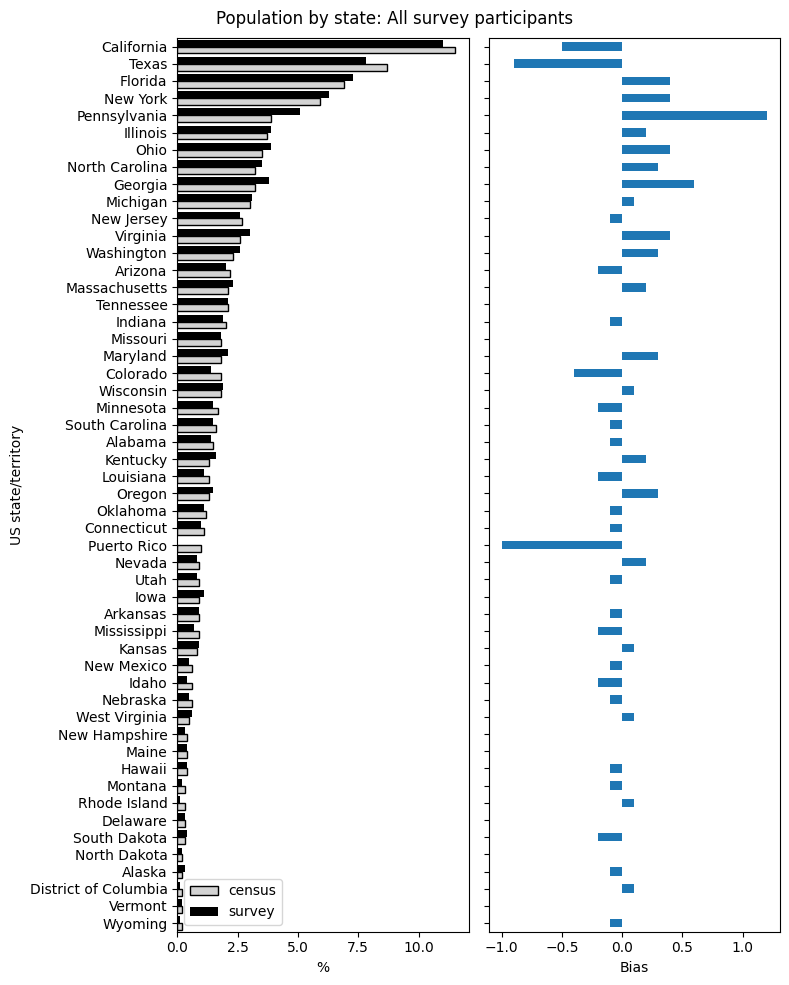

In [24]:
print('Comparing census to survey data:')
(r, pvalue) = pearsonr(state_pop_df[CENSUS_PCT], state_pop_df[SURVEY_PCT])
print('Pearson correlation (r, pvalue): (%0.3f, %0.3f)' % (r, pvalue))
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(8,10), sharey=True)
title = 'Population by state: All survey participants'
fig.suptitle(title)
_ax1 = plot_census_vs_survey_pops(census_data=state_pop_df.sort_values(CENSUS_PCT)[CENSUS_PCT], 
                                survey_data=state_pop_df.sort_values(CENSUS_PCT)[SURVEY_PCT],
                                ax=ax1)
# Plot bias
_ax2 = plot_bias(state_pop_df.sort_values(CENSUS_N)[CENSUS_PCT], 
                state_pop_df.sort_values(CENSUS_N)[SURVEY_PCT], ax=ax2)
plt.tight_layout()
plt.show()

Comparing census to survey data w/ browser attributes:
Pearson correlation (r, pvalue): (0.991, 0.000)


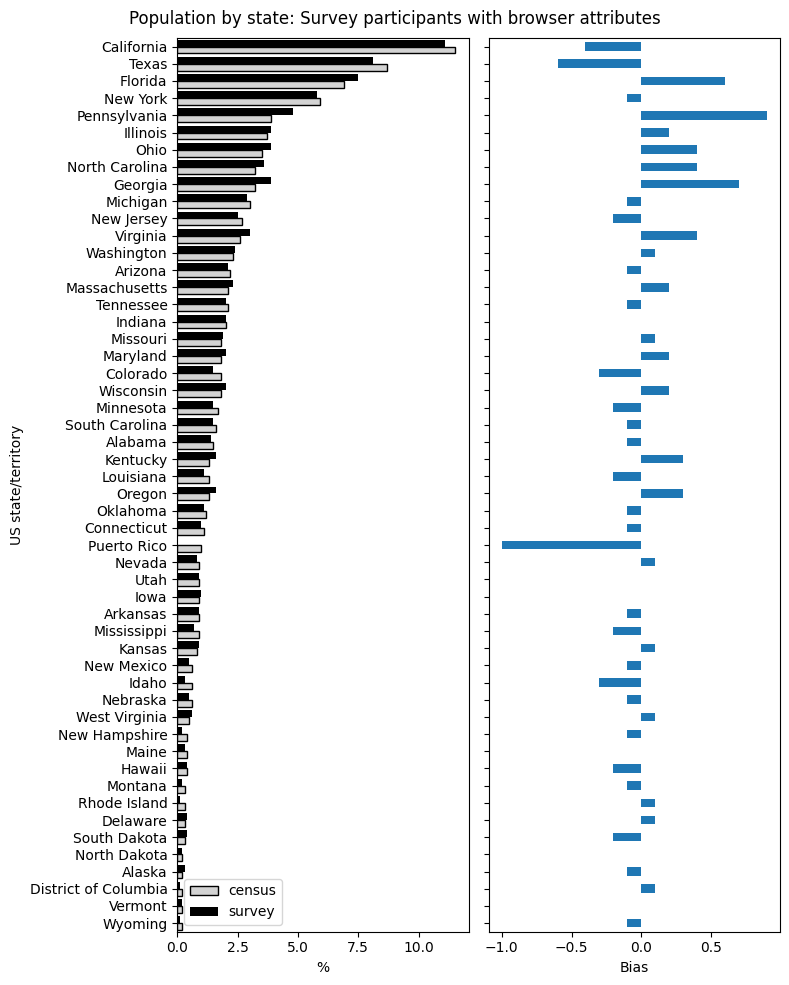

In [28]:
print('Comparing census to survey data w/ browser attributes:')
(r, pvalue) = pearsonr(state_pop_df[CENSUS_PCT], state_pop_df[SURVEY_W_BA_PCT])
print('Pearson correlation (r, pvalue): (%0.3f, %0.3f)' % (r, pvalue))

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(8,10), sharey=True)
title = 'Population by state: Survey participants with browser attributes'
fig.suptitle(title)
_ax1 = plot_census_vs_survey_pops(census_data=state_pop_df.sort_values(CENSUS_PCT)[CENSUS_PCT], 
                                survey_data=state_pop_df.sort_values(CENSUS_PCT)[SURVEY_W_BA_PCT], 
                                ax=ax1)
# Plot bias
_ax2 = plot_bias(state_pop_df.sort_values(CENSUS_N)[CENSUS_PCT], 
                state_pop_df.sort_values(CENSUS_N)[SURVEY_W_BA_PCT], ax=ax2)
plt.tight_layout()
plt.show()

Show difference between geographic distribution of entire survey participant sample vs survey participants who shared browser data.

i.e. check if there was a difference in sharing browser data across US states.

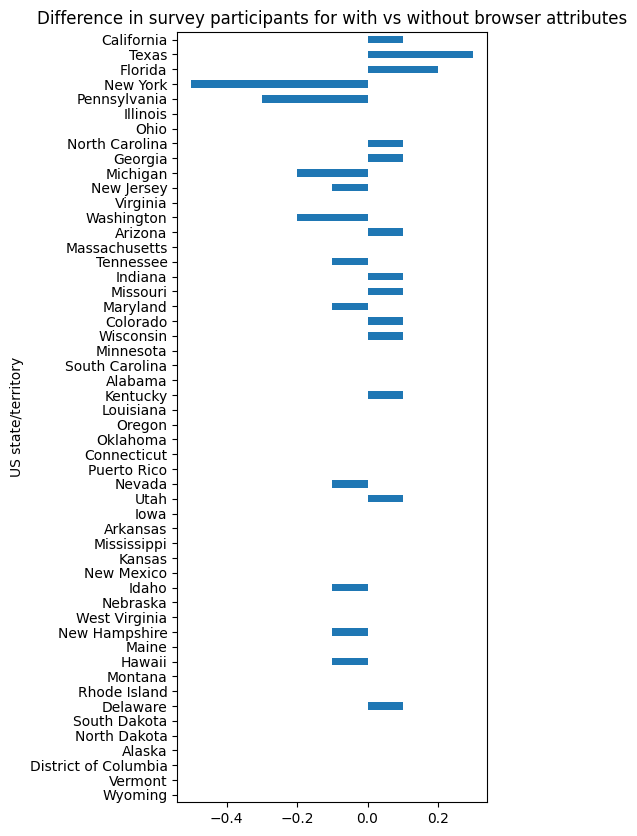

In [29]:
fig, ax = plt.subplots(figsize=(4,10), sharey=True)
title = 'Difference in survey participants for with vs without browser attributes'
ax.set_title(title)
_ = plot_bias(state_pop_df.sort_values(CENSUS_N)[SURVEY_PCT], 
                state_pop_df.sort_values(CENSUS_N)[SURVEY_W_BA_PCT], ax=ax2)

## Gender and Age


Using Census estimates from table NC-EST2022-ALLDATA, limiting data to the 18+ population in order to better compare to survey data.

Downloaded from: https://www2.census.gov/programs-surveys/popest/datasets/2020-2022/national/asrh/nc-est2022-alldata-r-file08.csv

File information: https://www2.census.gov/programs-surveys/popest/technical-documentation/file-layouts/2020-2022/NC-EST2022-ALLDATA.pdf

Data includes estimates up to 12-2023. I cut the CSV to only include 12-2023 estimates.

999 indicates total population.

> NC-EST2022-ALLDATA: Monthly Population Estimates by Age, Sex, Race, and Hispanic
Origin for the United States: April 1, 2020 to July 1, 2022 (With short-term projections to
December 2023)

File: 7/1/2022 National Population Estimates

Source: U.S. Census Bureau, Population Division

Release date: June 2023

In [30]:
# Read in just the total age + sex data columns, ignoring the columns that divide the info by race.
# Limit the data to the 18+ population
nc_est = pd.read_csv(census_data_dir + 'NC-EST.csv', usecols=['AGE', 'TOT_POP','TOT_MALE','TOT_FEMALE'])
# limit the data to 18+ population
age_sex = nc_est[nc_est.apply(lambda row: ((18 <= row['AGE']) and (row['AGE'] <= 100)), axis=1)]
age_sex.head()

,AGE,TOT_POP,TOT_MALE,TOT_FEMALE
19,18,4333706,2219773,2113933
20,19,4335471,2220278,2115193
21,20,4342640,2223921,2118719
22,21,4395728,2244653,2151075
23,22,4638779,2358079,2280700


### Gender / Sex

Compute the totals for sex, limiting census data to the 18+ population.

We recruited participants with an expected 50/50 balance.

Rhere are fewer Female participants than we would expect. This may mean Female participants exited the survey at the first point of granting consent, meaning they are already exhibiting more privacy protective behavior than what the consent/decline portion of the experiment can measure.

In [32]:
print(fields_df.loc['Q-demos-gender']['Text']) 
gender_df = survey_df['Q-demos-gender'].value_counts().sort_index().rename(SURVEY_N).to_frame()
gender_df[SURVEY_PCT] = get_percent_col(gender_df[SURVEY_N])
gender_df[SURVEY_W_BA_N] = survey_ba_df['Q-demos-gender'].value_counts().sort_index()
gender_df[SURVEY_W_BA_PCT] = get_percent_col(gender_df[SURVEY_W_BA_N])
gender_df[CENSUS_N] = [age_sex['TOT_FEMALE'].sum(), age_sex['TOT_MALE'].sum(), np.nan]
gender_df[CENSUS_PCT] = get_percent_col(gender_df[CENSUS_N])
gender_df

How do you describe yourself?


,Survey N,Survey %,Survey w BA N,Survey w BA %,Census N,Census %
Q-demos-gender,,,,,,
Female,6113,48.6,4025,47.3,134171563.0,50.9
Male,6201,49.3,4292,50.5,129657434.0,49.1
Other,252,2.0,184,2.2,NaN,NaN


### Age

Computing the number and proportion of participants in each age group, comparing to census data, limited to the 18+ population.

In [33]:
# collect the census data
census_age_df = age_sex[['AGE', 'TOT_POP']].set_index('AGE')
# census_age_df

What is your age group?


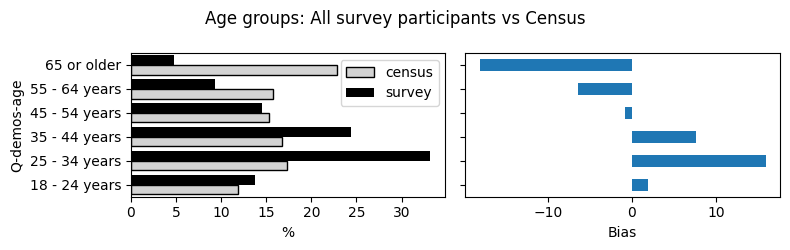

,Survey N,Survey %,Survey w BA N,Survey w BA %,Census N,Census %
Q-demos-age,,,,,,
18 - 24 years,1732,13.8,1307,15.4,31409108,11.9
25 - 34 years,4172,33.2,2893,34.0,45631055,17.3
35 - 44 years,3071,24.4,2056,24.2,44409212,16.8
45 - 54 years,1824,14.5,1178,13.9,40417493,15.3
55 - 64 years,1169,9.3,717,8.4,41479293,15.7
65 or older,598,4.8,350,4.1,60482836,22.9


In [35]:
print(fields_df.loc['Q-demos-age']['Text']) 
age_df = survey_df['Q-demos-age'].value_counts().sort_index().rename(SURVEY_N).to_frame()
age_df[SURVEY_PCT] = get_percent_col(age_df[SURVEY_N])
age_df[SURVEY_W_BA_N] = survey_ba_df['Q-demos-age'].value_counts().sort_index()
age_df[SURVEY_W_BA_PCT] = get_percent_col(age_df[SURVEY_W_BA_N])
age_df[CENSUS_N] = [
    census_age_df.loc[18:24]['TOT_POP'].sum(),
    census_age_df.loc[25:34]['TOT_POP'].sum(),
    census_age_df.loc[35:44]['TOT_POP'].sum(),
    census_age_df.loc[45:54]['TOT_POP'].sum(),
    census_age_df.loc[55:64]['TOT_POP'].sum(),
    census_age_df.loc[65:]['TOT_POP'].sum(),
]
age_df[CENSUS_PCT] = get_percent_col(age_df[CENSUS_N])
# plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8, 2.5), sharey=True)
title = 'Age groups: All survey participants vs Census'
fig.suptitle(title)
_ax1 = plot_census_vs_survey_pops(census_data=age_df.sort_index()[CENSUS_PCT], 
                                  survey_data=age_df.sort_index()[SURVEY_PCT], 
                                  ax=ax1)
_ax2 = plot_bias(age_df.sort_index()[CENSUS_PCT], age_df.sort_index()[SURVEY_PCT], ax=ax2)
plt.tight_layout()
plt.show()
age_df

Compared to Census data, our data:
- Under represents the older population, greatly under-representing the 65 and older population, and overall under representing the 55 and older population.
- Over-represents the younger populations, greatly over-representing the 25-34 population.

### Household income

U.S. household income data are from:
Table HINC-01. Selected Characteristics of Households by Total Money Income in 2022.

Downloaded December 2023 from https://www.census.gov/data/tables/time-series/demo/income-poverty/cps-hinc/hinc-01.html.

At time of analysis this is the most recent data.

Source:
> U.S. Census Bureau, Current Population Survey, 2023 Annual Social and Economic Supplement (CPS ASEC).	

The downloaded format is in a [spreadsheet here](https://docs.google.com/spreadsheets/d/1XJERVa9zvNKHQ8inGEMeRwCkFLtzjGpP3U0al0XmNJc/edit#gid=1000650822). I extracted the data for "All households" (without slicing by other demographic characteristics) for inclusion in this repository for analysis.
Data are reported in thousands.

In [90]:
# load census data
census_income_df = pd.read_csv(census_data_dir + 'hinc01-all-households.csv', thousands=',').transpose()
census_income_df.columns = ['N']
# print(census_income_df.index)
census_income_df.head()

,N
Total,131400
"Under $5,000",4305
"$5,000 to $9,999",2131
"$10,000 to $14,999",4536
"$15,000 to $19,999",4725


In [98]:
# survey data
print(fields_df.loc['Q-demos-income']['Text']) 
# sorted order
income_groups = [
    'Less than $25,000', '$25,000 - $49,999', '$50,000 - $74,999','$75,000 - $99,999',
    '$100,000 - $149,999', '$150,000 or more', 'Prefer not to say'
]
income_df = survey_df['Q-demos-income'].value_counts().rename(SURVEY_N).to_frame().reindex(income_groups)
income_df[SURVEY_PCT] = get_percent_col(income_df[SURVEY_N])
income_df[SURVEY_W_BA_N] = income_df.index.map(survey_ba_df['Q-demos-income'].value_counts())
income_df[SURVEY_W_BA_PCT] = get_percent_col(income_df[SURVEY_W_BA_N])
income_df = income_df.rename({
    'Less than $25,000': 'Less than \$25,000', 
    '$25,000 - $49,999': '\$25,000 - \$49,999', 
    '$50,000 - $74,999': '\$50,000 - \$74,999',
    '$75,000 - $99,999': '\$75,000 - \$99,999',
    '$100,000 - $149,999':'\$100,000 - \$149,999', 
    '$150,000 or more': '\$150,000 or more',
})
income_df

What was your total household income before taxes during the past 12 months?


,Survey N,Survey %,Survey w BA N,Survey w BA %
Q-demos-income,,,,
"Less than \$25,000",1601,12.7,1104,13.0
"\$25,000 - \$49,999",2732,21.7,1850,21.8
"\$50,000 - \$74,999",2568,20.4,1706,20.1
"\$75,000 - \$99,999",1928,15.3,1277,15.0
"\$100,000 - \$149,999",2058,16.4,1426,16.8
"\$150,000 or more",1408,11.2,994,11.7
Prefer not to say,271,2.2,144,1.7


In [99]:
# attach the census data, aggregating to the same income groups
income_df[CENSUS_N] = [
    census_income_df.loc[[
        'Under $5,000', '$5,000 to $9,999', '$10,000 to $14,999', '$15,000 to $19,999', '$20,000 to $24,999'
    ]]['N'].sum(),
    census_income_df.loc[[
        '$25,000 to $29,999', '$30,000 to $34,999', '$35,000 to $39,999', '$40,000 to $44,999', '$45,000 to $49,999'
    ]]['N'].sum(),
    census_income_df.loc[[
        '$50,000 to $54,999', '$55,000 to $59,999', '$60,000 to $64,999', '$65,000 to $69,999', '$70,000 to $74,999','$75,000 to $79,999'
    ]]['N'].sum(),
    census_income_df.loc[[
        '$75,000 to $79,999', '$80,000 to $84,999', '$85,000 to $89,999','$90,000 to $94,999', '$95,000 to $99,999'
    ]]['N'].sum(),
    census_income_df.loc[[
        '$100,000 to $104,999','$105,000 to $109,999', '$110,000 to $114,999', 
        '$115,000 to $119,999','$120,000 to $124,999', '$125,000 to $129,999', 
        '$130,000 to $134,999','$135,000 to $139,999', '$140,000 to $144,999'
    ]]['N'].sum(),
    census_income_df.loc[[
        '$150,000 to $154,999', '$155,000 to $159,999', '$160,000 to $164,999',
        '$165,000 to $169,999', '$170,000 to $174,999', '$175,000 to $179,999',
        '$180,000 to $184,999', '$185,000 to $189,999', '$190,000 to $194,999',
        '$195,000 to $199,999', '$200,000 and over'
    ]]['N'].sum(),
    np.nan,
]
income_df[CENSUS_PCT] = get_percent_col(income_df[CENSUS_N])
income_df

,Survey N,Survey %,Survey w BA N,Survey w BA %,Census N,Census %
Q-demos-income,,,,,,
"Less than \$25,000",1601,12.7,1104,13.0,20744.0,15.5
"\$25,000 - \$49,999",2732,21.7,1850,21.8,23901.0,17.9
"\$50,000 - \$74,999",2568,20.4,1706,20.1,24993.0,18.7
"\$75,000 - \$99,999",1928,15.3,1277,15.0,16205.0,12.1
"\$100,000 - \$149,999",2058,16.4,1426,16.8,20196.0,15.1
"\$150,000 or more",1408,11.2,994,11.7,27689.0,20.7
Prefer not to say,271,2.2,144,1.7,NaN,NaN


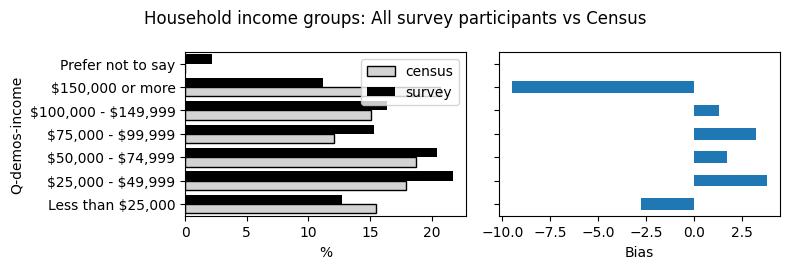

In [100]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8, 2.7), sharey=True)
title = 'Household income groups: All survey participants vs Census'
fig.suptitle(title)
_ax1 = plot_census_vs_survey_pops(census_data=income_df[CENSUS_PCT], 
                                  survey_data=income_df[SURVEY_PCT], 
                                  ax=ax1)
# Plot bias
_ax2 = plot_bias(income_df[CENSUS_PCT], income_df[SURVEY_PCT], ax=ax2)
plt.tight_layout()
plt.show()

Compared to census data, our data:
- greatly under-represents households making \$150k or more
- over-represents middle-income households
- under-represents households making less than \$25k

## Race and Hispanic Origin

The US Census asks about and records "hispanic origin" separately from "race", so our survey did as well.

Note the ACS uses "Hispanic", "Spanish" and "Latino" interchangeably.

Note that here we do not use Census data specific to the 18+ population. However, this could be done by using the NC-EST2022 data used for age and gender analysis above. 
See data notes: https://www2.census.gov/programs-surveys/popest/technical-documentation/file-layouts/2020-2022/NC-EST2022-ALLDATA.pdf.

We don't do this here because the 18+ numbers do not differ much from the overall population and because the data notes describe why the Race and Hispanic origin data in the NC-EST2022 release differs from the 2020 census.


### Hispanic or Latino Origin


We compare to US Census data estimates from:
> U.S. Census Bureau, American Community Survey (ACS).

Accessed via "QuickFacts" December 2023: https://www.census.gov/quickfacts/fact/table/US/RHI725222#RHI725222

Hispanic or Latino: 19.1%


In [41]:
# Our survey data
print(fields_df.loc['Q-demos-hispanic']['Text']) 
hispanic_df = survey_df['Q-demos-hispanic'].value_counts().sort_index().rename(SURVEY_N).to_frame()
hispanic_df[SURVEY_PCT] = get_percent_col(hispanic_df[SURVEY_N])
hispanic_df[SURVEY_W_BA_N] = survey_ba_df['Q-demos-hispanic'].value_counts().sort_index()
hispanic_df[SURVEY_W_BA_PCT] = get_percent_col(hispanic_df[SURVEY_W_BA_N])
hispanic_df

Are you of Spanish, Hispanic, or Latino origin?


,Survey N,Survey %,Survey w BA N,Survey w BA %
Q-demos-hispanic,,,,
No,11215,89.2,7571,89.1
Yes,1351,10.8,930,10.9


### Race

Data are from:
> U.S. Census Bureau, American Community Survey (ACS)

Accessed via "QuickFacts" December 2023: https://www.census.gov/quickfacts/fact/table/US

Here Census N=334,914,895

The Census Bureau reports on race with the following categories:

In [63]:
census_race_names = [
    "White alone", "Black or African American alone","Asian alone", "American Indian and Alaska Native alone",
    "Native Hawaiian and Other Pacific Islander alone", "Two or More Races"
]
census_race_df = pd.DataFrame({
    'Race': census_race_names, 
    CENSUS_PCT: [75.5, 13.6,6.3,1.3,0.3,3.0]
}).set_index('Race')
census_race_df

,Census %
Race,
White alone,75.5
Black or African American alone,13.6
Asian alone,6.3
American Indian and Alaska Native alone,1.3
Native Hawaiian and Other Pacific Islander alone,0.3
Two or More Races,3.0


Our survey allowed participants to select multiple options for race, including an option for "Other".
In order to make our data comparable to US Census data, we also report on the above races "alone" and group all responses with either multiple race selections or "Other" to "Other or mixed" and compare this to Census data for "Two or More Races".

This may result in data descrepancies where we over represent the category for "Other or mixed" and under represent other categories; other users of this dataset may prefer to aggregate race information differently.

In the below tables, the race categories report on that race "alone" unless the category is "Other or mixed".


In [49]:
# Our survey data
Q = 'Q-demos-race'
print(fields_df.loc[Q]['Text'])
survey_df[Q].value_counts().head()

Choose one or more races that you consider yourself to be


Q-demos-race
White or Caucasian           8894
Black or African American    1419
Asian                        1193
Other                         297
White or Caucasian,Asian      180
Name: count, dtype: int64

In [80]:
def handle_other_or_mixed(r):
    return 'Other or mixed' if ('other' in r.lower() or len(r.split(',')) > 1) else r
    
race_df = survey_df[Q].apply(handle_other_or_mixed).value_counts().rename(SURVEY_N).to_frame()
race_df[SURVEY_PCT] = get_percent_col(race_df[SURVEY_N])
race_df[SURVEY_W_BA_N] = race_df.index.map(survey_ba_df[Q].apply(handle_other_or_mixed).value_counts())
race_df[SURVEY_W_BA_PCT] = get_percent_col(race_df[SURVEY_W_BA_N])
race_df.rename({
    'White or Caucasian': 'White',
    'Native Hawaiian or Other Pacific Islander':'Native Hawaiian or Other Pacific Islander',
    'American Indian/Native American or Alaska Native': 'American Indian or Alaska Native',
}, inplace=True)

In [81]:
# Attach the census data and set the desired order for the categories
race_df = race_df.merge(census_race_df.rename({
    'White alone': 'White',
    'Asian alone': 'Asian',
    'Black or African American alone':'Black or African American',
    'American Indian and Alaska Native alone': 'American Indian or Alaska Native', 
    'Two or More Races': 'Other or mixed'
}), how='outer', left_index=True, right_index=True).fillna(0).reindex([ # Set the desired order for the categories
    'White', 
    'Black or African American',
    'Asian',
    'American Indian or Alaska Native', 
    'Native Hawaiian and Other Pacific Islander alone', 
    'Other or mixed',
])
race_df

,Survey N,Survey %,Survey w BA N,Survey w BA %,Census %
White,8894.0,70.8,5971.0,70.2,75.5
Black or African American,1419.0,11.3,957.0,11.3,13.6
Asian,1193.0,9.5,856.0,10.1,6.3
American Indian or Alaska Native,75.0,0.6,53.0,0.6,1.3
Native Hawaiian and Other Pacific Islander alone,0.0,0.0,0.0,0.0,0.3
Other or mixed,985.0,7.8,664.0,7.8,3.0


Pearson correlation when comparing all survey participants to census data (r, pvalue): (0.996, 0.000)
When comparing data for survey participants who shared browser attributes to census data (r, pvalue): (0.995, 0.000)


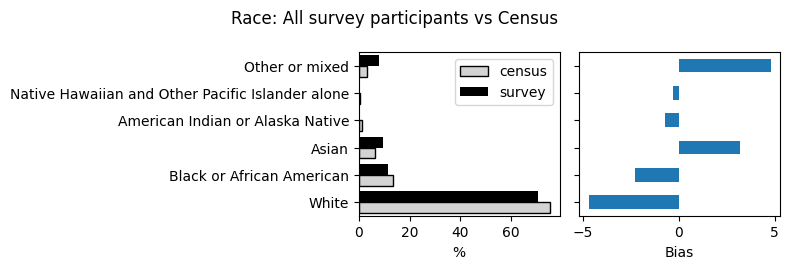

In [85]:
# Calculate Pearson correlation
(r, pvalue) = pearsonr(race_df[SURVEY_PCT], race_df[CENSUS_PCT])
print('Pearson correlation when comparing all survey participants to census data (r, pvalue): (%0.3f, %0.3f)' % (r, pvalue))
(r, pvalue) = pearsonr(race_df[SURVEY_W_BA_PCT], race_df[CENSUS_PCT])
print('When comparing data for survey participants who shared browser attributes to census data (r, pvalue): (%0.3f, %0.3f)' % (r, pvalue))
# plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8, 2.7), sharey=True)
title = 'Race: All survey participants vs Census'
fig.suptitle(title)
_ax1 = plot_census_vs_survey_pops(census_data=race_df[CENSUS_PCT], 
                                  survey_data=race_df[SURVEY_PCT], 
                                  ax=ax1)
_ax2 = plot_bias(race_df[CENSUS_PCT], race_df[SURVEY_PCT], ax=ax2)
plt.tight_layout()
plt.show()